In [120]:
#$roslaunch realsense2_camera rs_rgbd.launch

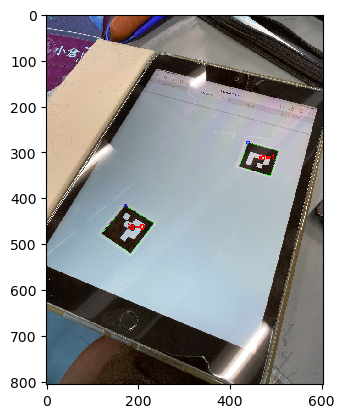

In [57]:
import cv2 
from cv2 import aruco
import numpy as np
import os
import math
import matplotlib.pyplot as plt
alpha = 87*math.pi/180
beta = 58*math.pi/180
#depthの取得はここでできそう
#https://qiita.com/keoitate/items/efe4212b0074e10378ec

p_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
img = cv2.imread("sample.jpg")
img=cv2.resize(img,(int(img.shape[1]/5.0),int(img.shape[0]/5.0)))
# 実際にはRealsenseで読み込んだ画像topic
corners, ids, rejectedImgPoints = aruco.detectMarkers(img, p_dict) # 検出
# cornersは 検出マーカー数×4×2という形
# 左上から時計回りに格納
#　idsは 検出マーカー数*1 二重になってるんで注意
img_marked = aruco.drawDetectedMarkers(img.copy(), corners, ids)   # 検出結果をオーバーレイ
plt.imshow(img_marked)

In [18]:
print(corners)

(array([[[ 864., 2083.],
        [1183., 2280.],
        [ 925., 2609.],
        [ 602., 2392.]]], dtype=float32), array([[[2205., 1399.],
        [2539., 1490.],
        [2454., 1763.],
        [2105., 1663.]]], dtype=float32))


In [123]:
import math
def dist_line_pt(lp0,lp1,p):
  #lp0とlp1で結ばれた直線と点pの距離を求める
  (x1,y1)=lp0
  (x2,y2)=lp1
  # 直線の方程式は(y1-y2)*x+(x2-x1)*y+(x1*y2-x2*y1)=0
  return ((y1-y2)*p[0]+(x2-x1)*p[1]+(x1*y2-x2*y1))/math.sqrt((y1-y2)**2+(x2-x1)**2)


0
[[0]
 [1]]
[[1110. 1241.]
 [1208. 1188.]
 [1260. 1292.]
 [1160. 1345.]]
[[1102.  779.]
 [1179.  716.]
 [1243.  793.]
 [1166.  858.]]
[1172.5  786.5]
-200.5667277935977


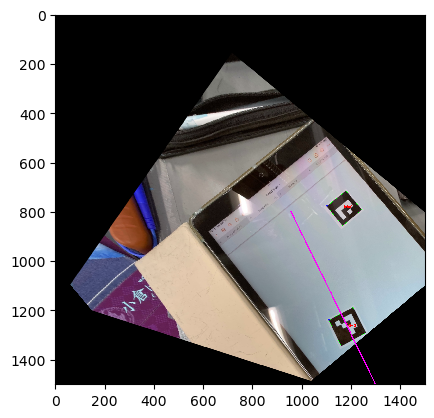

In [124]:
offset_x = 1000
offset_y = 1000

pts2 = np.array([[0.0,0.0],[100.0,0.0],[100.0,100.0],[0.0,100.0]]).astype(np.float32)
pts2[:,0]+=offset_x
pts2[:,1]+=offset_y
#np.where(ids==np.array([0]))
print(np.where(ids==[0])[0][0])
M = cv2.getPerspectiveTransform(corners[np.where(ids==[1])[0][0]],pts2)

img_rec = cv2.warpPerspective(img,M,(1500,1500))
# transposeは左右反転で読めなくなるので注意
rotate_matrix = cv2.getRotationMatrix2D(center=(img_rec.shape[0]/2,img_rec.shape[1]/2), angle=40, scale=1)
img_rec = cv2.warpAffine(src=img_rec, M=rotate_matrix, dsize=(img_rec.shape[0],img_rec.shape[1]))

# 投影変換したらもう一回detect
corners2, ids2, rejectedImgPoints2 = aruco.detectMarkers(img_rec, p_dict) # 検出
print(ids2)
img_marked = aruco.drawDetectedMarkers(img_rec.copy(), corners2, ids2)   # 検出結果をオーバーレイ

# 0番マーカーの4点を取得して、重心を通る直線をひく
marker_0 = corners2[np.where(ids==[0])[0][0]][0]
print(marker_0)
front = (marker_0[0]+marker_0[1])/2.0
rear = (marker_0[2]+marker_0[3])/2.0
img_marked = cv2.line(img_marked,((front-rear)*5+rear).astype(int),((rear-front)*5+front).astype(int),(255,0,255),thickness=3)
plt.imshow(img_marked)


# 1番マーカーの4点から重心を取得
marker_1 = corners2[np.where(ids==[1])[0][0]][0]
print(marker_1)
marker_1_g=np.average(marker_1,axis=0)
print(marker_1_g)
print(dist_line_pt(front,rear,marker_1_g))

# pts2の長さを調整すれば、depthを使わずとも絶対的な距離が出る
# 後ろに下がれない以上、到着判定も作る必要がある

# marker1が見えなくなったら終了で良い？